In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [489]:
def to_hours(time):
    return (time // 3600) + 6

def clean_sales_data():
    df = pd.read_csv("../data/master_data/sales_data.csv")
    sales_df = df[['token_id', 'sold_at', 'price']]
    sales_df = sales_df.rename(columns={'token_id': 'horse_id', 'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
    sales_df['timestamp'] = sales_df['time_sold'].apply(to_hours)

    return sales_df

In [490]:
sales_data = clean_sales_data()

In [491]:
eth_prices = pd.read_csv('../data/master_data/eth_price_history.csv')
eth_prices.tail()

,Unnamed: 0,timestamp,eth_price
9091,9091,464923,1533.01
9092,9092,464924,1529.65
9093,9093,464925,1535.38
9094,9094,464926,1538.76
9095,9095,464927,1550.97


In [492]:
merged = pd.merge(sales_data, eth_prices, left_on='timestamp', right_on='timestamp', how='left')
merged['converted_price'] = merged['price'] * merged['eth_price']
clean_market_data = merged.drop(columns=['Unnamed: 0', 'price', 'timestamp','eth_price'])
clean_market_data.shape

def to_day(unix_time):
    return datetime.date.fromtimestamp(unix_time)

clean_market_data['day_sold'] = clean_market_data['time_sold'].apply(to_day)
clean_market_data

,horse_id,time_sold,converted_price,day_sold
0,27,1650124789,60665.000,2022-04-16
1,68,1657313128,13934.205,2022-07-08
2,75,1657313072,9693.360,2022-07-08
3,89,1657313100,9693.360,2022-07-08
4,92,1663112422,10943.775,2022-09-13
...,...,...,...,...
74906,520344,1673482196,139.492,2023-01-11
74907,520345,1673514341,138.079,2023-01-12
74908,520346,1673487400,139.884,2023-01-11
74909,520404,1673622818,499.436,2023-01-13


### Deal with outliers

In [493]:
# Calculate the z-score for each data point
clean_market_data['z_score'] = np.abs((clean_market_data['converted_price'] - np.mean(clean_market_data['converted_price'])) / np.std(clean_market_data['converted_price']))

clean_market_data
market_data_no_outliers = clean_market_data[clean_market_data['z_score'] < 3]
print(clean_market_data.shape, market_data_no_outliers.shape, f'=> {74911 - 74820} data points removed')

(74911, 5) (74820, 5) => 91 data points removed


In [494]:
# horse data cleaning
horse_data = pd.read_csv('../data/master_data/all_horse_meta_oliver.csv')
horse_data.columns
horse_data = horse_data.rename(columns={'data.horse.bloodline':'bloodline', 'data.horse.breed_type':'breed_type',
                           'data.horse.breeding_counter':'breeding_counter', 'data.horse.color':'horse_color',
                           'data.horse.horse_type':'horse_type', 'data.horse.img_url':'img_url',
                           'data.horse.last_breeding_reset':'last_breeding_reset', 'data.horse.name':'horse_name',
                           'data.horse.nft_id':'nft_id', 'data_horse_offsprings':'offsprings',
                           'data.horse.race_statistic.first_place_finishes':'first_place_finishes',
                           'data.horse.race_statistic.number_of_races':'number_races',
       'data.horse.race_statistic.second_place_finishes':'second_place_finishes',
       'data.horse.race_statistic.third_place_finishes':'third_place_finishes',
       'data.horse.race_statistic.win_rate':'win_rate',
                                        'data.horse.gen':'genotype'})
horse_data = horse_data.drop(columns=['Unnamed: 0'])
# print(horse_data.nft_id)
horse_data.head()

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat
0,Buterin,genesis,Anti-Flash White,Z9,Mare,https://img.zed.run/horses/F2F3F4.png,2021-07-09T15:47:37,Sneaky Flirt,42102,[],8,4.60,174,53,227,0.0,15,16,3.52,False
1,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],17,5.03,318,20,338,5.0,25,35,5.03,False
2,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",0,0.00,12,0,12,0.0,0,0,0.00,False
3,Buterin,pacer,Ghost White,Z268,Stallion,https://img.zed.run/horses/FFFFFF.png,2022-06-29T07:34:16,King Crew,435325,"[{'name': 'King Gerardo', 'nft_id': 416984}, {...",0,0.00,7,0,7,0.0,0,0,0.00,False
4,Buterin,pacer,Antique White,Z268,Filly,https://img.zed.run/horses/FAEBD7.png,2022-06-29T07:35:25,Queen Iliana,435326,"[{'name': 'Z268 White Smoke IV', 'nft_id': 382...",0,0.00,20,0,20,0.0,0,1,0.00,False


In [495]:
# code to merge horse data with sales data
test_merge = pd.merge(horse_data,market_data_no_outliers, right_on='horse_id', left_on='nft_id', how='left')
test_merge

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,...,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,day_sold,z_score
0,Buterin,genesis,Anti-Flash White,Z9,Mare,https://img.zed.run/horses/F2F3F4.png,2021-07-09T15:47:37,Sneaky Flirt,42102,[],...,0.0,15,16,3.52,False,42102.0,1.672836e+09,86.945520,2023-01-04,0.025410
1,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],...,5.0,25,35,5.03,False,42104.0,1.669888e+09,102.400000,2022-12-01,0.025328
2,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],...,5.0,25,35,5.03,False,42104.0,1.669113e+09,73.711300,2022-11-22,0.025480
3,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",...,0.0,0,0,0.00,False,435320.0,1.658539e+09,10.752347,2022-07-22,0.025814
4,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",...,0.0,0,0,0.00,False,435320.0,1.660522e+09,4.137903,2022-08-14,0.025849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,Buterin,legendary,Sienna,Z19,Filly,https://img.zed.run/horses/3C1414.png,2022-01-01T12:55:15,The Battle of Waterloo,178394,"[{'name': 'Bourbon App', 'nft_id': 42271}, {'n...",...,0.0,3,4,2.94,False,178394.0,1.672748e+09,12.082800,2023-01-03,0.025807
3420,Nakamoto,exclusive,Egyptian Blue,Z4,Colt,https://img.zed.run/horses/1034A6.png,2022-07-09T20:38:17,The Last Castle,440538,"[{'name': 'Robert Redford', 'nft_id': 126172},...",...,0.0,0,0,0.00,False,440538.0,1.660949e+09,122.085750,2022-08-19,0.025224
3421,Buterin,exclusive,Bittersweet Shimmer,Z16,Colt,https://img.zed.run/horses/BF4F51.png,2022-01-01T12:56:09,Cobain,178396,"[{'name': 'Underground Railroad', 'nft_id': 14...",...,0.0,0,1,4.55,False,178396.0,1.672748e+09,12.082800,2023-01-03,0.025807
3422,Finney,exclusive,Pale Violet,Z14,Colt,https://img.zed.run/horses/DB7093.png,2022-01-01T13:04:18,Marcelo Mayer,178397,"[{'name': 'Merry Mathews', 'nft_id': 158850}, ...",...,0.0,0,0,0.00,False,178397.0,1.672748e+09,12.082800,2023-01-03,0.025807


## Exploratory Data Analysis

### Price Distribution

<AxesSubplot: xlabel='converted_price'>

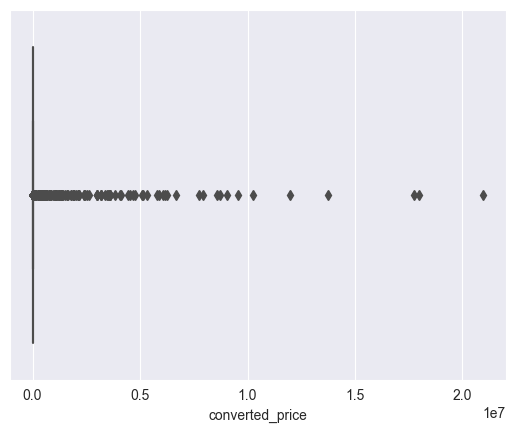

In [496]:
sns.boxplot(data = clean_market_data, x='converted_price', color='red')
# plt.xlim(0,20000)
# plt.ylim(0,80)

The distribution of prices is highly right skewed.

### Win rate vs Price

<AxesSubplot: xlabel='win_rate', ylabel='converted_price'>

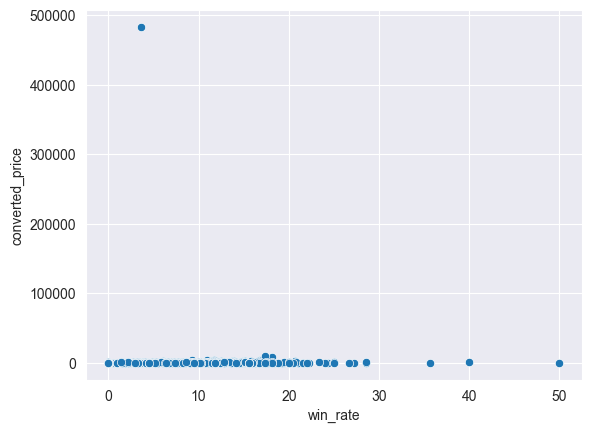

In [497]:
sns.scatterplot(data=test_merge, x='win_rate', y='converted_price')

### Different Factors by Breed

In [498]:
by_breed = test_merge.groupby('breed_type').mean().reset_index()
by_breed

C:\Users\dgnic\AppData\Local\Temp\ipykernel_27044\2082808561.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_breed = test_merge.groupby('breed_type').mean().reset_index()


,breed_type,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,cross,394938.956897,7.275862,4.916121,83.370690,8.637931,92.008621,2.218017,7.237069,7.103448,4.796724,0.021552,394938.956897,1.660811e+09,16.293469,0.025784
1,elite,404384.154955,12.702703,6.864396,133.888288,26.556757,160.445045,3.237640,13.893694,14.039640,6.431459,0.016216,404323.709386,1.661595e+09,28.804531,0.025718
2,exclusive,371172.755595,20.972247,7.951755,177.027753,54.641898,231.669651,3.605918,20.457475,20.100269,7.427547,0.008953,371172.755595,1.660635e+09,96.877773,0.025357
3,genesis,44763.161172,21.653846,6.927271,187.294872,70.996337,258.291209,4.234487,21.520147,21.093407,6.528553,0.000000,44754.764273,1.660681e+09,318.581339,0.024182
4,legendary,346283.031250,20.397135,7.784883,199.865885,46.917969,246.783854,3.135312,22.148438,22.408854,7.218438,0.010417,346283.031250,1.660116e+09,813.382296,0.028271
5,pacer,402671.995146,3.126214,1.907961,41.436893,4.373786,45.810680,0.884757,2.752427,2.747573,1.848398,0.048544,402671.995146,1.659285e+09,15.385531,0.025789


Text(0.5, 1.0, 'Mean Win Rate by Breed Type')

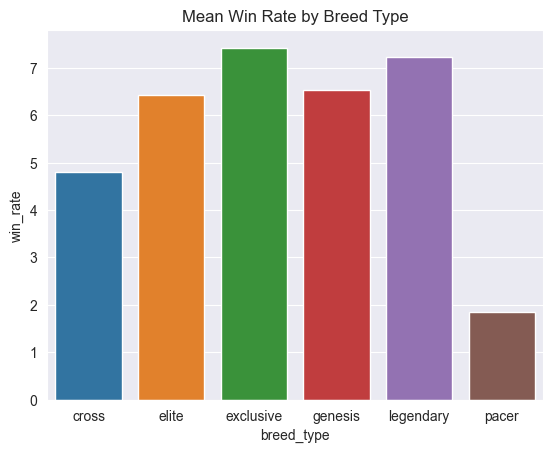

In [499]:
sns.barplot(data=by_breed, x='breed_type', y='win_rate')
plt.title('Mean Win Rate by Breed Type')

Text(0.5, 1.0, 'Mean Number of 1st Place Finishes by Breed')

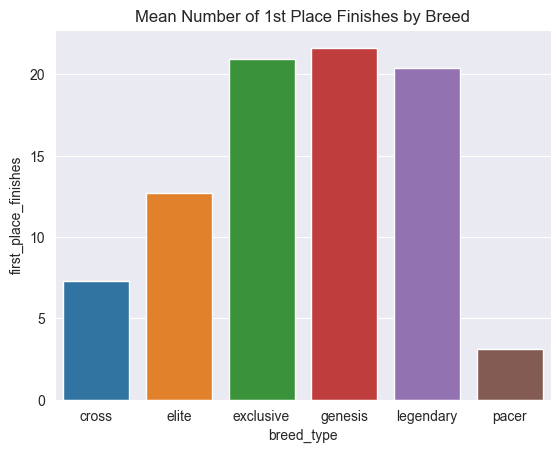

In [500]:
sns.barplot(data=by_breed, x='breed_type', y='first_place_finishes')
plt.title('Mean Number of 1st Place Finishes by Breed')

<AxesSubplot: xlabel='breed_type', ylabel='converted_price'>

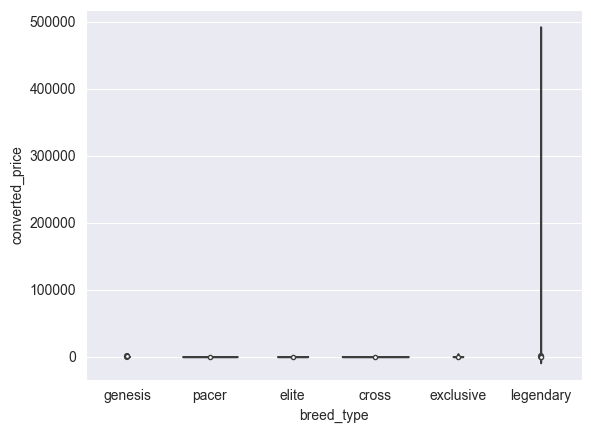

In [501]:
sns.violinplot(data=test_merge, x='breed_type', y='converted_price')

### Different Factors by Bloodline

In [502]:
by_blood = test_merge.groupby('bloodline').mean().reset_index()
by_blood

C:\Users\dgnic\AppData\Local\Temp\ipykernel_27044\1323334638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_blood = test_merge.groupby('bloodline').mean().reset_index()


,bloodline,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,Buterin,257253.895142,15.659360,6.007577,142.645735,39.690758,182.336493,3.002618,14.824645,14.183057,5.702210,0.015995,257522.479216,1.660274e+09,405.368369,0.026733
1,Finney,374311.626230,16.347541,7.293016,156.178689,34.936066,191.114754,3.646016,16.265574,16.544262,6.977148,0.016393,374311.626230,1.660813e+09,37.268299,0.025673
2,Nakamoto,405414.094541,20.985353,8.543356,191.773635,58.013316,249.786951,3.566818,23.677763,24.197071,7.775326,0.003995,405414.094541,1.661063e+09,254.596672,0.024633
3,Szabo,365212.920000,21.682667,7.949120,201.624000,57.597333,259.221333,3.387520,23.573333,23.946667,7.326213,0.005333,365212.920000,1.660899e+09,85.895627,0.025415


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Buterin'),
  Text(1, 0, 'Finney'),
  Text(2, 0, 'Nakamoto'),
  Text(3, 0, 'Szabo')])

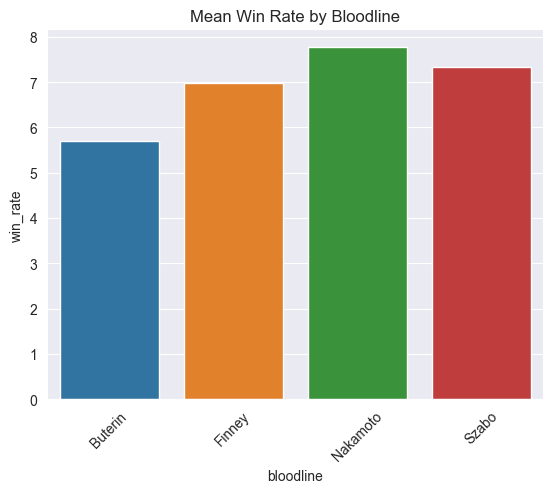

In [503]:
sns.barplot(data=by_blood, x='bloodline', y='win_rate')
plt.title('Mean Win Rate by Bloodline')
plt.xticks(rotation = 45)

<AxesSubplot: xlabel='day_sold', ylabel='converted_price'>

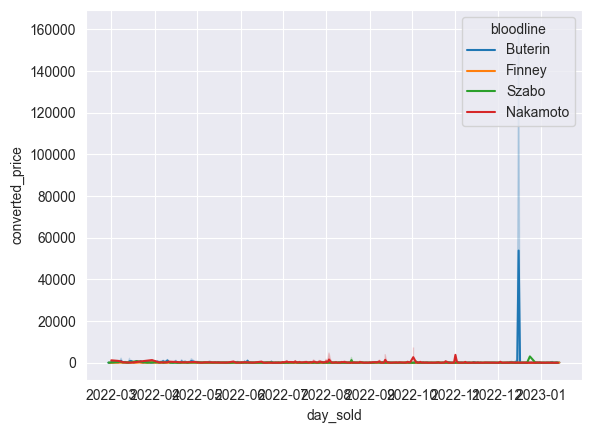

In [504]:
sns.lineplot(data=test_merge, x='day_sold', y='converted_price', hue= 'bloodline')